In [1]:
import torch
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from optimizer import LGSO, LCSO, normalize_vector
from problems import ShipMuonShield, make_index, ShipMuonShieldCuda
import torch
import pickle
import numpy as np
import time
from tqdm import trange

In [2]:
dim = (
    make_index(0, [0,1,2,4,6,8,12,14]) +
    make_index(1, [0,1,2,3,4,5,6,7,8,9,14]) +
    make_index(2, [0,1,2,3,4,5,6,7,8,9,14]) +
    make_index(3, [0,1,2,3,4,5,6,7,8,9,14]) +
    make_index(4, [0,1,2,3,4,5,6,7,8,9,12,14]) +
    make_index(5, [0,1,2,3,4,5,6,7,8,9,12,14]) +
    make_index(6, [0,1,2,3,4,5,6,7,8,9,12,14]))

initial_phi = torch.tensor(ShipMuonShield.params["tokanut_v5"])

# Minimal ShipMuonShield setup for fast LGSO test
problem = ShipMuonShieldCuda(
            uniform_fields=False,  # No real field simulation
            n_samples=0,       
            apply_det_loss=False,  # Skip detector loss for speed
            loss_fn='hits',
            reduction='none',
            cost_loss_fn=None,     # No cost penalty
            dimensions_phi=dim,
            initial_phi=initial_phi,
            parallel = False,
            fSC_mag = False,
            use_B_goal = True,
            muons_file = "/home/hep/lprate/projects/MuonsAndMatter/data/muons/subsample_biased_v4.npy",
            fields_file = "/home/hep/lprate/projects/MuonsAndMatter/data/outputs/fields_rob.h5",
            sensitive_plane = [{'dz': 0.01, 'dx': 4, 'dy': 6,'position': 82}]
        )

initial_phi = problem.initial_phi
bounds = problem.GetBounds(device=torch.device('cpu'))

In [3]:
class BinaryClassifierModel:
    """
    A wrapper class to handle training and prediction for a given binary classification model.
    It is not an nn.Module itself, but it manages one.
    """
    def __init__(self,
                phi_dim: int,
                 x_dim: int,
                 n_epochs: int = 50,
                 batch_size: int = 32,
                 lr: float = 1e-3,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        
        self.device = device

        self.model = torch.nn.Sequential(
            torch.nn.Linear(phi_dim + x_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)  # Output layer for binary classification
        ).to(self.device)

        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self._lr = lr
        # Use BCEWithLogitsLoss for better numerical stability. It combines Sigmoid and BCELoss.
        self.loss_fn = torch.nn.BCEWithLogitsLoss() 
        self.last_train_loss = []

    def fit(self, condition, y):
        """
        Trains the classifier model.
        """
        self.model.train() # Set the wrapped model to training mode
        self.last_train_loss = []
        
        # Ensure y is the correct shape [batch_size, 1] and type for the loss function
        y = y.view(-1, 1).float() 

        num_samples = y.size(0)
        indices = torch.arange(num_samples)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self._lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        print(f"--- Starting Binary Classifier Training on {self.device} ---")
        pbar = trange(self.n_epochs, position=0, leave=True, desc='Classifier Training')

        for epoch in pbar:
            average_loss = 0.0
            # Shuffle indices for each epoch
            shuffled_indices = indices[torch.randperm(num_samples)]
            
            for start in range(0, num_samples, self.batch_size):
                end = min(start + self.batch_size, num_samples)
                batch_idx = shuffled_indices[start:end]
                
                y_batch = y[batch_idx].to(self.device)
                condition_batch = condition[batch_idx].to(self.device)
                optimizer.zero_grad()
                
                # Get model prediction (logits)
                y_pred_logits = self.model(condition_batch)
                
                # Calculate loss
                loss = self.loss_fn(y_pred_logits, y_batch)
                
                assert not torch.isnan(loss), "Loss is NaN, check your model and data."
                
                loss.backward()
                optimizer.step()
                
                average_loss += loss.item() * (end - start)
            
            average_loss /= num_samples
            self.last_train_loss.append(average_loss)
            scheduler.step()
            
            pbar.set_description(f"Epoch {epoch+1}, Loss: {average_loss:.4f}")
            pbar.set_postfix(loss=f"{average_loss:.4f}", lr=f"{optimizer.param_groups[0]['lr']:.6f}")
            
        print(f"Final training loss: {self.last_train_loss[-1]:.4f}")
        print("--- Binary Classifier Training Finished ---")
        return self

    def predict_proba(self, condition):
        """
        Predicts the probability of Y=1 for each given `phi` and `x`.
        """
        self.model.eval()
        condition = condition.to(self.device)
        y_pred_logits = self.model(condition)
        y_pred_prob = torch.sigmoid(y_pred_logits)
        
        return y_pred_prob

In [4]:
files_dir = "/home/hep/lprate/projects/BlackBoxOptimization/tests_notebooks/"
start_time = time.time()
local_info = (torch.from_numpy(np.load(files_dir + "local_info_0.npy")),
              torch.from_numpy(np.load(files_dir + "local_info_1.npy")))
print(f"File loaded in {time.time() - start_time:.4f} seconds.")
print("Data shape: ", local_info[0].shape, local_info[1].shape)

N = local_info[0].reshape(-1, 87).shape[0]

File loaded in 27.5338 seconds.
Data shape:  torch.Size([101, 5000000, 87]) torch.Size([101, 5000000, 1])


In [5]:
generative_model = BinaryClassifierModel(phi_dim=80,
                            x_dim = 7,
                            n_epochs = 15,
                            batch_size = 2**20,
                            lr = 1e-2,
                            device = 'cuda')
generative_model.fit(local_info[0].reshape(-1, 87), local_info[1].reshape(-1, 1))

--- Starting Binary Classifier Training on cuda ---


Epoch 15, Loss: 0.0147: 100%|██████████| 15/15 [13:28<00:00, 53.88s/it, loss=0.0147, lr=0.000010]

Final training loss: 0.0147
--- Binary Classifier Training Finished ---


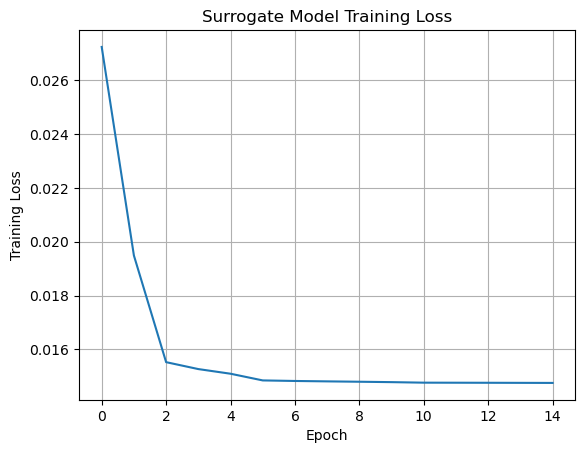

In [6]:
plt.figure()
plt.plot(generative_model.last_train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Surrogate Model Training Loss')
plt.grid(True)
plt.show() 

In [7]:
sur_loss = []
with torch.no_grad():
    for b in local_info[0]:
        batch_loss = generative_model.predict_proba(b).sum().cpu()
        sur_loss.append(batch_loss)
sur_loss = torch.stack(sur_loss)
true_loss = local_info[1].sum(1).flatten()

In [8]:
true_loss.shape

torch.Size([101])

In [9]:
sur_loss

tensor([  1015.9277,   3904.2615,   2539.6562,   2316.3772,  18354.0000,
         25315.8555,  15034.2266,  60210.7930,  84816.4219,   2702.5835,
          7419.0703,   7646.1260,   7937.0562,  11241.5312,    502.6646,
           401.8620,  19186.1289,   5509.7349,   1838.3898, 108343.1875,
          5995.4014,   4475.9736,   2228.3335,  71638.7656,   1765.3268,
          2224.7607,  28388.6875,   6434.7129,  26948.6836,  39591.9922,
           722.6416,    945.6404,  64283.4805,   3589.7092,   1737.4390,
        133645.2188,  51662.3359,   1074.4598,  35671.0703,  28228.2695,
          1292.0574,  66778.3281,  28937.9531,   3722.4653,   5952.5098,
         39145.2969,  78947.5469, 132913.3594,  13194.2314,   3126.7844,
          1806.9382,   2197.1284,   1414.4006,   2249.2236,  21476.5293,
         28068.6055,   4059.2134,  84974.7500,   4529.3931,  51545.0625,
         64069.9766,   1483.5029,   2934.5542,   6455.8652,   9929.3584,
         46477.2188,   3737.4194,  29384.1641,    4

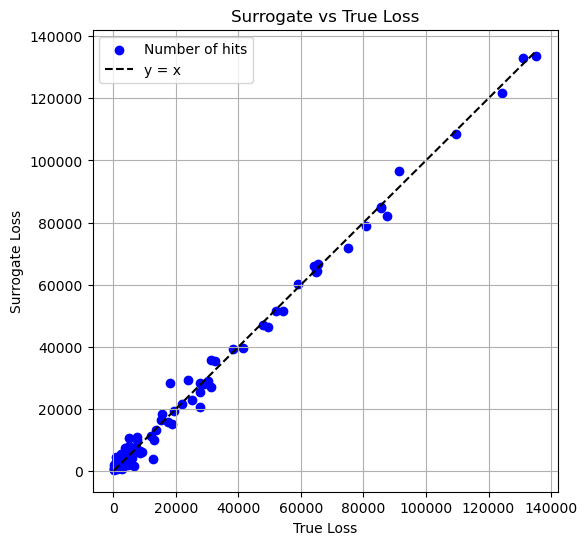

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(true_loss, sur_loss, color='blue', label='Number of hits')
plt.plot([true_loss.min().item(), true_loss.max().item()],
         [true_loss.min().item(), true_loss.max().item()],
         'k--', label='y = x')
plt.xlabel('True Loss')
plt.ylabel('Surrogate Loss')
plt.title('Surrogate vs True Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def get_local_info(phi):
    """
    Computes loss, gradient, and Hessian in a memory-efficient, batched manner.
    """

    phi_norm = normalize_vector(phi, bounds)
    x_all = torch.as_tensor(problem.sample_x(), dtype=phi.dtype, device=phi.device)
    n = x_all.size(0)

    total_loss = torch.tensor(0.0, dtype=phi.dtype, device=phi.device)
    total_grad = torch.zeros_like(phi)
    total_hess = torch.zeros(phi.numel(), phi.numel(), dtype=phi.dtype, device=phi.device)

    def compute_batch_loss(phi_norm, xb):
        cond = torch.cat([phi_norm.repeat(xb.size(0), 1), xb[:, :7]], dim=-1)
        y_pred = generative_model.predict_proba(cond).cpu()
        w = xb[:,7].to(y_pred.device).flatten()
        y_pred = y_pred.flatten()
        return  (w*y_pred).sum()

    grad_func_batch = torch.func.grad(compute_batch_loss)
    hess_func_batch = torch.func.hessian(compute_batch_loss)

    for start in range(0, n, 5000):
        xb = x_all[start: start + 5000]
        batch_loss = compute_batch_loss(phi_norm, xb).detach()
        batch_grad = grad_func_batch(phi_norm, xb).detach()
        batch_hess = hess_func_batch(phi_norm, xb).detach()
        total_loss += batch_loss
        total_grad += batch_grad
        total_hess += batch_hess
    return total_loss, total_grad, total_hess

def calc_delta_loss_torch(delta_phi: torch.Tensor, 
                          grad: torch.Tensor, 
                          hess: torch.Tensor,
                          normalize = False) -> float:
    """
    Estimates the change in loss for a given parameter perturbation using PyTorch.

    This function uses a second-order Taylor expansion to estimate the change
    in the loss function (delta_loss) based on the local gradient and Hessian.

    Args:
        delta_phi: The expected parameter perturbation (a 1D torch.Tensor).
        grad: The gradient of the loss function at the current point (a 1D torch.Tensor).
        hess: The Hessian matrix of the loss function at the current point (a 2D torch.Tensor).

    Returns:
        The estimated change in loss (a scalar float).
    """
    # Linear term: (∇L)ᵀ * δφ
    def normalize_delta(d, lower_bound, upper_bound):
        return d / (upper_bound - lower_bound)

    if normalize: delta_phi = normalize_delta(delta_phi, bounds[0], bounds[1])
    linear_term = torch.dot(grad, delta_phi)

    # Quadratic term: 0.5 * δφᵀ * H * δφ
    # The @ operator performs matrix-vector multiplication
    quadratic_term = 0.5 * torch.dot(delta_phi, hess @ delta_phi)

    # The result is a 0-dimensional tensor; .item() extracts the Python scalar
    return (linear_term + quadratic_term).item()

In [12]:
sur_loss_initial_phi, grad, hess = get_local_info(initial_phi)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5000x84 and 87x256)

In [ ]:
print(f"Initial True Loss: {true_loss[0].item()}")
print(f"Initial Hessian: {hess}")
eigenvalues, eigenvectors = torch.linalg.eigh(hess)
# Sort eigenvalues and eigenvectors by eigenvalue (descending)
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
print(f"Hessian eigenvalues: {eigenvalues}")
for idx, (eigval, eigvec) in enumerate(zip(eigenvalues, eigenvectors.T)):
    print(f"Eigenvalue {idx}: {eigval.item()}")
    print(f"Eigenvector {idx}: {eigvec}")
alphas = np.linspace(-2, 2, 100)
print(f"Initial Surrogate Loss: {sur_loss[0].item()}")
print(f"Initial Gradient: {grad}")

In [ ]:
grad

In [ ]:
unnormalized_vec = eigenvectors.T[0] * (bounds[1] - bounds[0]) + bounds[0]
unnormalized_vec

In [ ]:
# --- New plot: all delta_phi directions in one figure with subplots (2 columns) ---
fig, axes = plt.subplots(nrows=(len(eigenvectors.T)+1)//2, ncols=2, figsize=(12, 3*((len(eigenvectors.T)+1)//2)))
axes = axes.flatten()
for idx, eigvec in enumerate(eigenvectors.T):
    delta_losses = []
    for alpha in alphas:
        delta_phi = alpha * eigvec
        delta_loss = calc_delta_loss_torch(delta_phi, grad, hess, normalize=False)
        delta_losses.append(delta_loss+ sur_loss_initial_phi.item())
    axes[idx].plot(alphas, delta_losses)
    axes[idx].set_xlabel('alpha')
    axes[idx].set_ylabel('Delta Loss')
    axes[idx].set_title(f'Eigenvector {idx}')
    axes[idx].grid(True)
# Hide unused subplots if any
for ax in axes[len(eigenvectors.T):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# --- Plot all delta_phi directions in one single plot ---
plt.figure(figsize=(10, 6))
d_phi = grad
for idx, eigvec in enumerate(eigenvectors.T):
    delta_losses = []
    for alpha in alphas:
        delta_phi = alpha * d_phi
        delta_loss = calc_delta_loss_torch(delta_phi, grad, hess, normalize=False)
        delta_losses.append(delta_loss + sur_loss_initial_phi.item())
    plt.plot(alphas, delta_losses, label=f'Eigenvector {idx}')
plt.xlabel('alpha')
plt.ylabel('Delta Loss')
plt.title('Delta Loss along Eigenvector Directions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
